In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from scipy.linalg import cholesky, lstsq


In [3]:
from experiments import MoreTraceGases, Sensors
from experiments import utilities as utils
from bayesinverse import Regression

In [4]:
config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/more_trace_gases/config.yaml"
)

exp = MoreTraceGases(config_path)
# basic_setup.run()


sensors 0.016176939010620117
emissions 10.320614472031593
transport 45.95360514521599


In [5]:
exp.sensors_config

{'n_sensors': 10, 'height': 0, 'noise': 1.0, 'seed': 2, 'time': 100}

In [6]:
# CO2 sensors
exp.sensors_co2 = Sensors(exp.sensors_config)

# CO sensors
co_config = exp.sensors_config
co_config["noise"] = .01
co_config["seed"] = 5
exp.sensors_co = Sensors(exp.sensors_config)

In [7]:
exp.K = exp.transport.get_transport(
    n_sensors=exp.sensors_co2.n_sensors + exp.sensors_co.n_sensors,
    sensors_index=utils.concatenate_indices(
        exp.sensors_co2.get_index(), exp.sensors_co.get_index()
    ),
    emissions=exp.emissions,
    n_processes=32
)

# Multiply with emission factor
em_factors_co = exp.emissions.get_emission_factors()[exp.emissions.mask]
em_factors = xr.DataArray(em_factors_co, dims=["source_group"])
em_factors
# sensor, time_measurement, source_group, time_state
exp.K[exp.sensors_co2.n_sensors:,] *= em_factors

loop start 60.70774157345295
loop end 60.91864889860153


In [11]:
noise = xr.concat(
    [exp.sensors_co2.get_noise(), exp.sensors_co.get_noise()], dim="sensor"
)
covariance = xr.concat(
    [exp.sensors_co2.get_covariance(), exp.sensors_co.get_covariance()], dim="sensor"
)

In [12]:
# exp.emissions.prior_covariance = utils.compute_prior_covariance(
#     xr_prior_var=exp.emissions.prior_variance,
#     tau_h=2.00,
#     tau_d=1,
# )

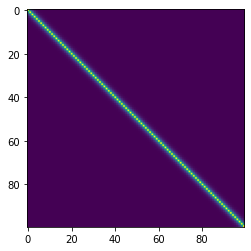

In [43]:
plt.imshow(utils.stack_xr(exp.emissions.prior_covariance)[:100, :100])

In [13]:
exp.reg = Regression(
    y=utils.stack_xr(
        exp.K.isel(sensor=slice(exp.sensors_co2.n_sensors)) @ exp.emissions.truth
        + noise.isel(sensor=slice(exp.sensors_co2.n_sensors))
    ).values,
    K=utils.stack_xr(exp.K.isel(sensor=slice(exp.sensors_co2.n_sensors))).values,
    x_prior=utils.stack_xr(exp.emissions.prior).values,
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
    y_covariance=utils.stack_xr(covariance.isel(sensor=slice(exp.sensors_co2.n_sensors))).values,
)
x_est, res, rank, s = exp.reg.fit()
posterior = exp.emissions.to_xr(x_est)


In [14]:
exp.reg_combined = Regression(
    y=utils.stack_xr(exp.K @ exp.emissions.truth + noise).values,
    K=utils.stack_xr(exp.K).values,
    x_prior=utils.stack_xr(exp.emissions.prior).values,
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
    y_covariance=utils.stack_xr(covariance).values,
)
x_est, res, rank, s = exp.reg_combined.fit()
posterior_combined = exp.emissions.to_xr(x_est)

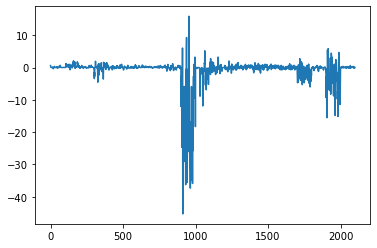

In [15]:
plt.plot(utils.stack_xr(posterior_combined - posterior))

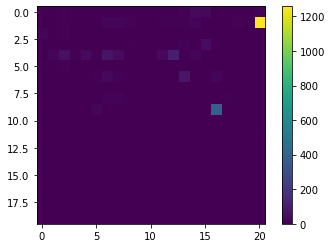

In [16]:
im = plt.imshow(exp.K.sum(dim=["time_state", "time_measurement"]))
plt.colorbar()

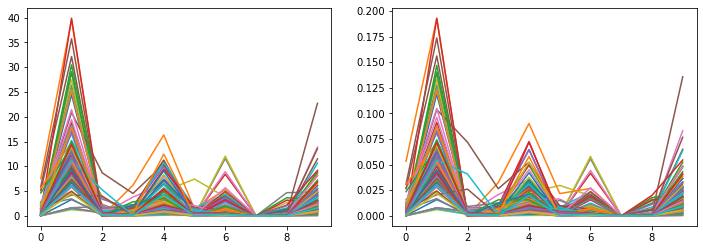

In [17]:
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(121)
plt.plot((exp.K @ exp.emissions.truth)[:exp.sensors_co2.n_sensors])
plt.subplot(122)
plt.plot((exp.K @ exp.emissions.truth)[exp.sensors_co2.n_sensors:])
pass

In [18]:
true_emissions = exp.emissions.get_absolute()[exp.emissions.mask]
posterior = utils.unstack_xr(posterior) * true_emissions
# To xarray
posterior_covariance = exp.emissions.to_xr(exp.reg.get_posterior_covariance())
# Multiply with emissions
posterior_covariance = utils.unstack_xr(posterior_covariance) * true_emissions
posterior_covariance = posterior_covariance * true_emissions.rename(
    source_group="source_group_2"
)


In [19]:
posterior_combined = utils.unstack_xr(posterior_combined) * true_emissions
# To xarray
posterior_combined_covariance = exp.emissions.to_xr(exp.reg_combined.get_posterior_covariance())
# Multiply with emissions
posterior_combined_covariance = utils.unstack_xr(posterior_combined_covariance) * true_emissions
posterior_combined_covariance = posterior_combined_covariance * true_emissions.rename(
    source_group="source_group_2"
)


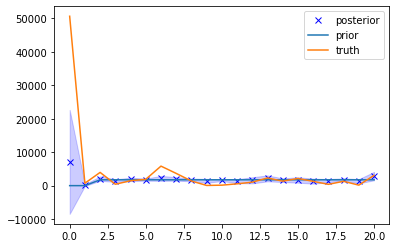

In [20]:
mean = utils.unstack_xr(posterior).mean("time_state")
std = utils.unstack_xr(posterior).std("time_state")
line = plt.plot(mean, "bx", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

plt.plot(exp.emissions.prior_absolute.mean("time_state"), label="prior")
plt.plot(exp.emissions.truth_absolute.mean("time_state"), label="truth")
plt.legend()

In [21]:
var = []
for coor, sub_arr in posterior_covariance.groupby('time_state'):
    cov = sub_arr.sel(time_state_2=coor).isel(source_group=slice(1, None))
    var.append(utils.var_of_sum(cov))

In [22]:
var_combined = []
for coor, sub_arr in posterior_combined_covariance.groupby('time_state'):
    cov = sub_arr.sel(time_state_2=coor).isel(source_group=slice(1, None))
    var_combined.append(utils.var_of_sum(cov))

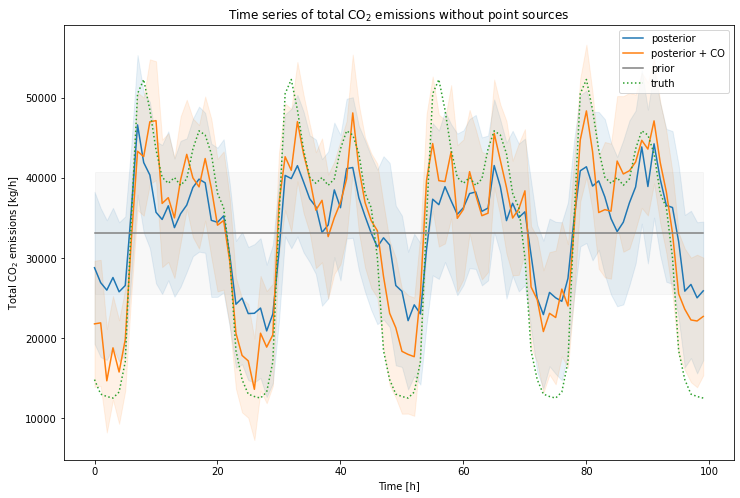

In [39]:
plt.figure(figsize=(12, 8))
mean = posterior.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var)
line = plt.plot(mean, "-", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1, color=line._color)

mean = posterior_combined.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior + CO")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1, color=line._color)

mean_prior = exp.emissions.prior_absolute.isel(source_group=slice(1, None)).sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance.isel(source_group=slice(1, None))
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, color="grey", label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.05,
    color=line._color,
)

plt.plot(
    exp.emissions.truth_absolute.isel(source_group=slice(1, None)).sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
# print((mean - mean_prior).mean())
plt.title(r"Time series of total CO$_2$ emissions without point sources")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig(
    "/home/rmaiwald/results/preliminary/more_trace_gases_timeseries_no_point_sources"
)


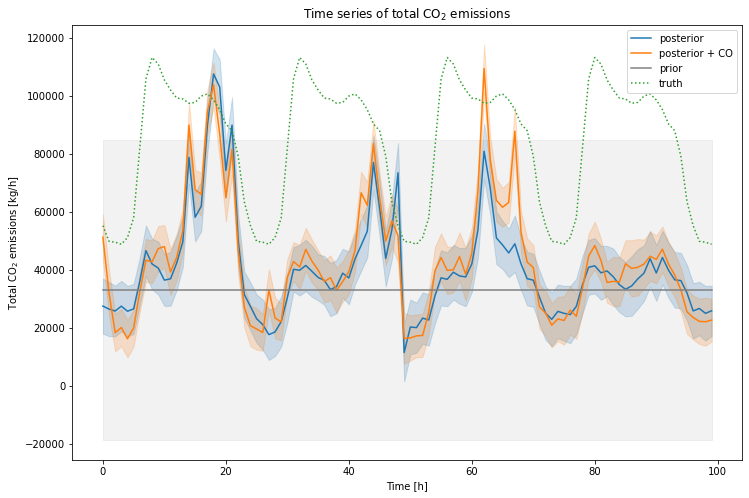

In [40]:
plt.figure(figsize=(12, 8))
mean = posterior.sum("source_group")
std = np.sqrt(var)
line = plt.plot(mean, "-", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean = posterior_combined.sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior + CO")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean_prior = exp.emissions.prior_absolute.sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, color="grey", label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.1,
    color=line._color,
)

plt.plot(
    exp.emissions.truth_absolute.sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
# print((mean - mean_prior).mean())
plt.title(r"Time series of total CO$_2$ emissions")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig("/home/rmaiwald/results/preliminary/more_trace_gases_timeseries")

<xarray.DataArray ()>
array(475.32741)


Text(0, 0.5, 'Total CO$_2$ emissions [kg/h]')

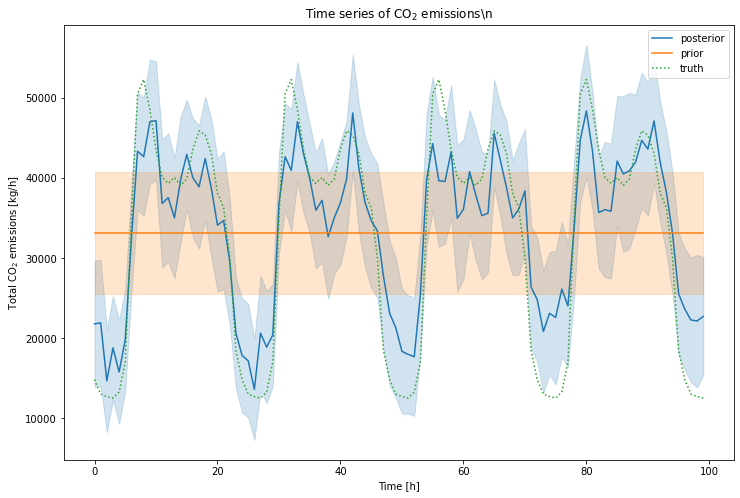

In [25]:
plt.figure(figsize=(12, 8))
mean = posterior_combined.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean_prior = exp.emissions.prior_absolute.isel(source_group=slice(1, None)).sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance.isel(source_group=slice(1, None))
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.2,
    color=line._color,
)

plt.plot(
    exp.emissions.truth_absolute.isel(source_group=slice(1, None)).sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
print((mean - mean_prior).mean())
plt.title(r"Time series of CO$_2$ emissions\n")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig("/home/rmaiwald/results/preliminary/more_trace_gases_timeseries")

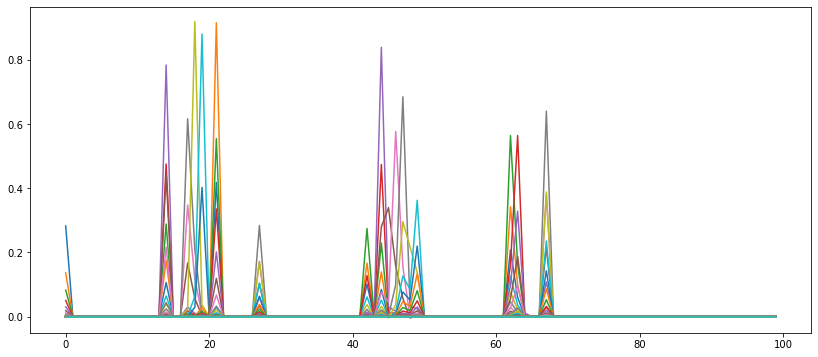

In [22]:
plt.figure(figsize=(14, 6))
averaging_kernel = exp.reg.get_averaging_kernel()
# for i in range(averaging_kernel.shape[0]):
for i in range(100):
    kernel = averaging_kernel[i]
    plt.plot(kernel[:100], label=kernel.sum())
    # print(kernel.sum())
# plt.legend()


In [23]:
posterior

<xarray.DataArray (source_group: 21, time_state: 100)>
array([[-1.67065842e+03, -8.05635684e+02, -3.59172068e+02, ...,
         8.50687105e-10,  2.61358201e-10,  1.26043704e-09],
       [ 4.51370560e+00,  5.87764790e+00,  9.97252125e+00, ...,
        -1.01005353e+02, -1.32226453e+02, -5.86532897e+01],
       [ 1.36583318e+03,  1.23526319e+03,  1.23776175e+03, ...,
         1.39675363e+03,  1.52255980e+03,  1.68520796e+03],
       ...,
       [ 1.64360090e+03,  1.61291274e+03,  1.56064111e+03, ...,
         1.31400408e+03,  1.12143623e+03,  1.46771877e+03],
       [ 1.52255437e+03,  1.52194503e+03,  1.53355241e+03, ...,
         1.18422139e+03,  1.43134869e+03,  1.67688253e+03],
       [ 1.36327260e+03,  1.32762276e+03,  1.45453444e+03, ...,
         1.04179204e+03,  1.83358219e+03,  7.88544588e+02]])
Coordinates:
  * source_group  (source_group) int64 1 2 21 22 23 24 25 ... 34 35 36 37 38 39
  * time_state    (time_state) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99

In [24]:
exp.emissions.prior_covariance  

<xarray.DataArray (source_group: 21, time_state: 100, time_state_2: 100,
                   source_group_2: 21)>
array([[[[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [6.06530660e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [3.67879441e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[6.06530660e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [6.06530660e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.88422596e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 3.10656342e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.88422596e-01]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.14284081e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.88422596e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 3.10656342e-01]]]])
Coordinates:
  * source_group_2  (source_group_2) int64 1 2 21 22 23 24 ... 34 35 36 37 38 39
  * source_group    (source_group) int64 1 2 21 22 23 24 ... 34 35 36 37 38 39
Dimensions without coordinates: time_state, time_state_2

In [25]:
averaging_kernel = exp.reg.get_averaging_kernel()
averaging_kernel = xr.DataArray(
    averaging_kernel,
    dims=["state", "state_2"],
    coords=utils.stack_xr(exp.emissions.prior_covariance).coords,
)

averaging_kernel = utils.unstack_xr(averaging_kernel)
averaging_kernel = (
    averaging_kernel
    * true_emissions
    / true_emissions.rename(source_group="source_group_2")
    # / (true_emissions**2).sum()
)
averaging_kernel = utils.stack_xr(averaging_kernel)


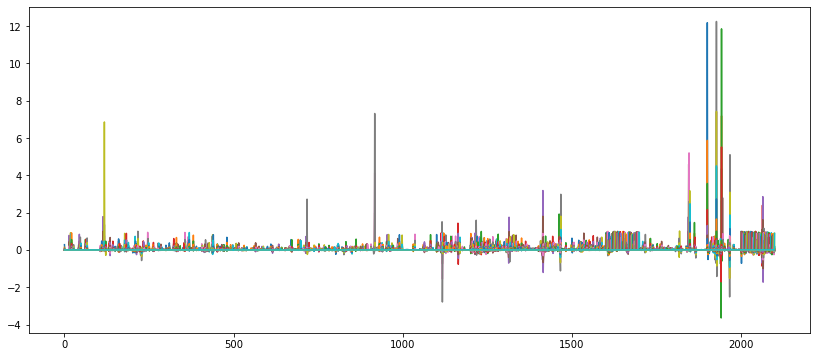

In [26]:
plt.figure(figsize=(14, 6))
# for i in range(averaging_kernel.shape[0]):
for i in range(averaging_kernel.shape[0]):
    kernel = averaging_kernel[i]
    plt.plot(kernel, label=kernel.sum())
    # print(kernel.sum())
# plt.legend()


In [27]:
for i in range(len(averaging_kernel["time_state"])):
    kernel = averaging_kernel.isel(time_state=i, time_state_2=i)
    plt.plot(kernel, label=kernel.sum())


ValueError: Dimensions {'time_state_2', 'time_state'} do not exist. Expected one or more of ('state', 'state_2')

0


TypeError: Invalid shape (21, 100, 21, 100) for image data

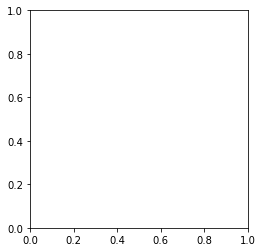

In [ ]:
print(np.where(averaging_kernel > 1., 1, 0).sum())
plt.imshow(np.where(averaging_kernel > 1., 1, 0))

In [ ]:
l = cholesky(np.diag(utils.stack_xr(exp.emissions.prior_covariance).values))
im = plt.imshow(l)
plt.colorbar(im)

ValueError: Input array is expected to be square but has the shape: (1, 2100).

In [ ]:
(utils.stack_xr(exp.emissions.truth_absolute).values
* exp.reg.get_posterior_covariance()
* utils.stack_xr(exp.emissions.truth_absolute).values.T).min()

-14212215641.29782

In [ ]:
(utils.stack_xr(exp.emissions.truth_absolute).values
* exp.reg.get_posterior_covariance()
* utils.stack_xr(exp.emissions.truth_absolute).values.T).max()

3892855502.133504

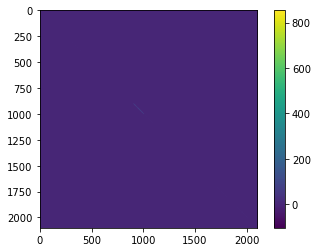

In [ ]:
im = plt.imshow(
    exp.reg.get_posterior_covariance()
)
plt.colorbar(im)


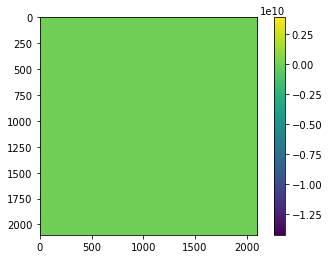

In [ ]:
im = plt.imshow(
    utils.stack_xr(exp.emissions.truth_absolute).values
    * exp.reg.get_posterior_covariance()
    * utils.stack_xr(exp.emissions.truth_absolute).values.T
)
plt.colorbar(im)


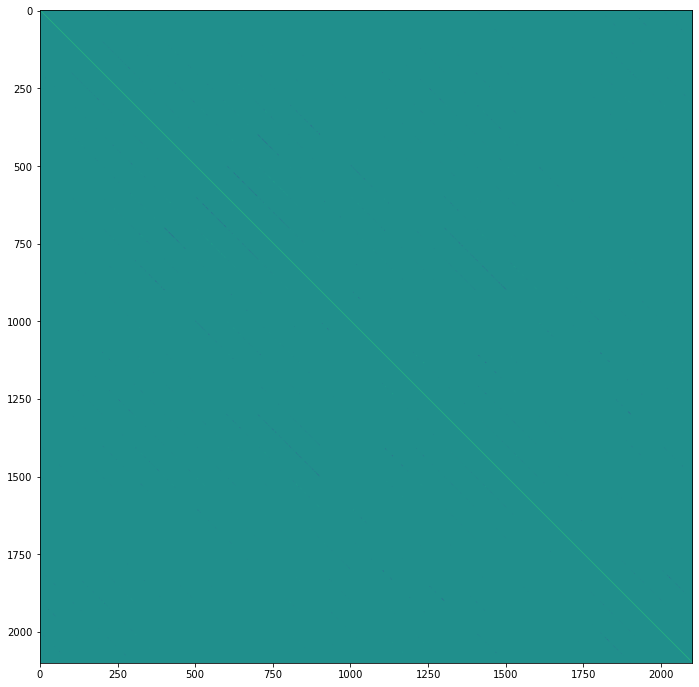

In [ ]:
plt.figure(figsize=(12,12))

plt.imshow(exp.reg.get_correlation())

In [ ]:
exp.reg.get_information_content(), exp.reg.get_dof_signal(), exp.reg.get_dof_noise()

/net/dsvr-01/home/rmaiwald/code/BayesInverse/bayesinverse/regression.py:496: RuntimeWarning: divide by zero encountered in log
  return -0.5 * np.log(


(inf, 866.8677530720804, 1233.1322469279196)

In [ ]:
-0.5 * np.log(np.abs(np.linalg.det(exp.reg.get_posterior_covariance() @ exp.reg.get_x_covariance_inv())))

/tmp/ipykernel_1075875/2513801941.py:1: RuntimeWarning: divide by zero encountered in log
  -0.5 * np.log(np.abs(np.linalg.det(exp.reg.get_posterior_covariance() @ exp.reg.get_x_covariance_inv())))


inf

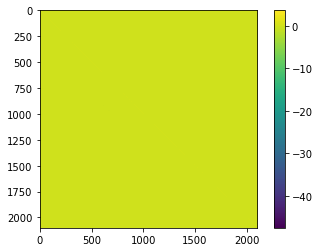

In [ ]:
im = plt.imshow(exp.reg.get_posterior_covariance() @ exp.reg.get_x_covariance_inv())
plt.colorbar(im)